In [5]:
#импортируем необходимые библиотеки


import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from tqdm import tqdm

%matplotlib inline

In [17]:
#определим устройство, где проводить вычисления (GPU или CPU)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
PATH = os.path.join(os.getcwd(),"data","dataset","hotdog")
print(PATH)


/home/dkuz/work/project/python-test-book/3ml/torchtest/data/dataset/hotdog


In [ ]:
# необходимо разпаковать датасет в окружение, делается это так:
# import zipfile
# with zipfile.ZipFile('/content/drive/My Drive/hotdog.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content/dataset')

In [18]:
#функция для вывода изображений
def image_shower(images, labels, n=4):
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i + 1)
        image = image/ 2 + 0.5
        plt.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
    print("Real Labels: ", ' '.join('%5s' % classes[label] for label in labels[:n]))
#имена классов
classes = ("hotgot", "not_hot_dog")




In [19]:
# зададим какие преобразования необходимо сделать с каждым изображением
transform = transforms.Compose(
    [transforms.Resize((64,64)),  #изменим размер изображений
     transforms.ToTensor(),   #переведем в формат который необходим нейронной сети - тензор
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])]) # проведем нормализацию изображения

#загружаем тренировочный и тестовый датасеты
trainset = torchvision.datasets.ImageFolder(os.path.join(PATH, "train"), transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=0, shuffle=True)

testset = torchvision.datasets.ImageFolder(os.path.join(PATH, "test"), transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0, shuffle=True)


Real Labels:  not_hot_dog not_hot_dog not_hot_dog not_hot_dog


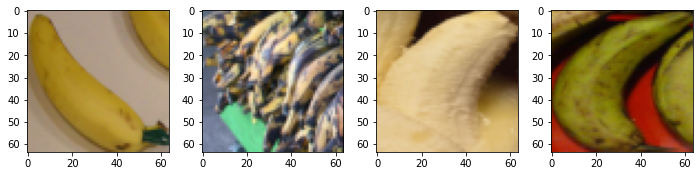

In [20]:
#Проверим как работает наш загрузчик и посмотрим на парочку изображений
images, labels = next(iter(trainloader))
image_shower(images, labels)

In [21]:
#загрузим нашу модель
model = torchvision.models.resnet18(pretrained=True)
#заморозим веса
for param in model.parameters():
    param.require = False

#так как у нас 2 класса, нужно переопределить последний слой сети под нашу задачу
#у предобученной сети было на выходе 1000 классов, поэтому в видео я сказал меняем 1000 на 2
model.fc = nn.Linear(512, 2)

In [22]:
#Зададим функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

In [23]:
#Здесь будет тренировка нейронной сети

epochs = 10   #количество эпох (сколько раз будем тренировать)
model.to(device) #переносим нашу модель на GPU

for epoch in range(epochs):
    running_loss = 0.0
    #теперь в цикле проходим по нашему загрузчику данных
    for i, data in tqdm(enumerate(trainloader)):
        #каждый батч тоже помещаем на GPU
        inputs, labels = data[0].to(device), data[1].to(device)
        #сбрасываем накопленный градиент 
        optimizer.zero_grad()
        #прогоняем изображения через модель, чтобы получить предсказание
        outputs = model(inputs)
        #рассчитываем функцию потерь (насколько хорошо предсказали)
        loss = criterion(outputs, labels)
        #считаем градиенты (обратный проход)
        loss.backward()
        #делаем шаг оптимизатора (обновляем веса)
        optimizer.step()

        running_loss += loss.item()

    print ("Epoch {} - Training loss: {} ".format(epoch, running_loss/len(trainloader)))

32it [00:23,  1.39it/s]


Epoch 0 - Training loss: 0.5178634207695723 


32it [00:22,  1.42it/s]


Epoch 1 - Training loss: 0.20616889465600252 


32it [00:24,  1.31it/s]


Epoch 2 - Training loss: 0.10293571616057307 


32it [00:23,  1.36it/s]


Epoch 3 - Training loss: 0.07117509481031448 


32it [00:22,  1.39it/s]


Epoch 4 - Training loss: 0.04204868839588016 


32it [00:23,  1.36it/s]


Epoch 5 - Training loss: 0.03131089371163398 


32it [00:23,  1.34it/s]


Epoch 6 - Training loss: 0.018171912495745346 


32it [00:25,  1.27it/s]


Epoch 7 - Training loss: 0.021876367638469674 


32it [00:23,  1.36it/s]


Epoch 8 - Training loss: 0.014898081324645318 


32it [00:22,  1.44it/s]

Epoch 9 - Training loss: 0.009457694104639813 


In [ ]:
#посчитаем точность работы нашего классификатора
correct = 0
total = 0
with torch.no_grad():
    #переводим модель в режим инференса
    model.eval()
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        #получаем наши предсказания
        _, predicted = torch.max(outputs.data, 1)
        #посчитаем общее количество картинок
        total += labels.size(0)
        #посчитаем количество точно классифицированных картинок
        correct += (predicted == labels).sum().item()
print("Accuracy: %d" %(100 * correct/total))


Accuracy: 68


Real Labels:  not_hot_dog not_hot_dog hotgot not_hot_dog
Predicted:  not_hot_dog not_hot_dog hotgot not_hot_dog


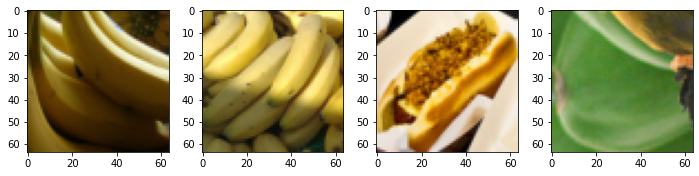

In [ ]:
images, labels = next(iter(testloader))
image_shower(images, labels)

outputs = model(images.to(device))

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join("%5s" %classes[predict] for predict in predicted[:4]))

In [ ]:
Спасибо за просмотр!!